# NY 2015 Street Tree Census EDA
This notebook contains code to perform exploratory data analysis (EDA) on the "NY 2015 Street Tree Census" dataset.

First, set up some config variables.

In [1]:
DATA_PATH = "../data/raw/2015-street-tree-census-tree-data.csv"

Fetch the data and print some high level statistics, such as the number of features and the number of data points (records).

In [2]:
import pandas as pd
df = pd.read_csv(DATA_PATH)
print(f"Extracted a dataset with {len(df.columns)} features (columns) and {len(df)} data points.")

# Data head is too bulky, therefore it's been commented out. Uncomment if you want to see it.
# print("-" * 40 + "DATA HEAD BELOW" + "-" * 40)
# print(df.head())

Extracted a dataset with 45 features (columns) and 683788 data points.


In [3]:
# Print the dataframe information.
# Summary: there are 19 numerical features (float & int) and 26 text features (object).
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 683788 entries, 0 to 683787
Data columns (total 45 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   tree_id           683788 non-null  int64  
 1   block_id          683788 non-null  int64  
 2   created_at        683788 non-null  object 
 3   tree_dbh          683788 non-null  int64  
 4   stump_diam        683788 non-null  int64  
 5   curb_loc          683788 non-null  object 
 6   status            683788 non-null  object 
 7   health            652172 non-null  object 
 8   spc_latin         652169 non-null  object 
 9   spc_common        652169 non-null  object 
 10  steward           164350 non-null  object 
 11  guards            79866 non-null   object 
 12  sidewalk          652172 non-null  object 
 13  user_type         683788 non-null  object 
 14  problems          225844 non-null  object 
 15  root_stone        683788 non-null  object 
 16  root_grate        68

In [4]:
# Check for duplicated values/rows.
df.duplicated().sum()

0

## Tree Health Distribution

Let's take a look at the distribution of the target class -- tree health.

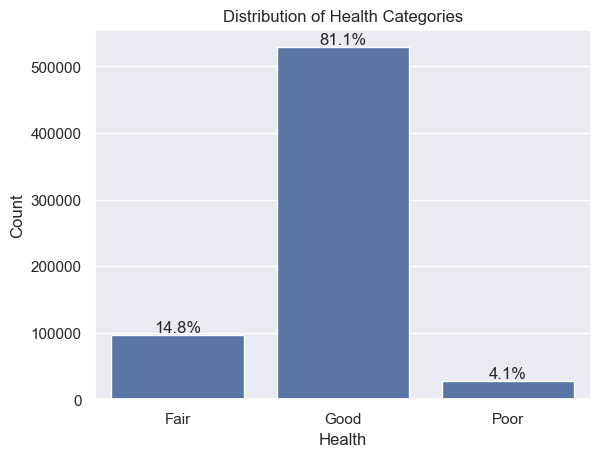

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme("notebook")

# Plot the distribution of the `health` column
ax = sns.countplot(x='health', data=df)

total = len(df[df['health'].notna()])
for p in ax.patches:
    count = p.get_height()
    percentage = f'{100 * count / total:.1f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom')

plt.title('Distribution of Health Categories')
plt.xlabel('Health')
plt.ylabel('Count')
plt.show()


As you can see, most of the data (around 80%) is occupied by one class -- `Good` health. While the imbalance is not TOO extreme, it must be accounted for in the future. Given the small size of the dataset, we will likely **NOT** drop records for balancing the data, but instead we will tweak the loss function during training to force the model to concentrate on harder examples.

## Cleaning Up the Data

Drop some irrelevant features/columns or rows. The following columns are dropped:
<ul>
    <li> <b>Tree ID</b> -- this has no meaningful contribution to predicting the tree health.
    <li> <b>State</b> -- all records are from New York, hence this field carries no meaningful information.
    <li> <b>Stump diameter</b> -- because we removed all the stumps from our analysis, we don't need this column.
    <li> <b>Tree status</b> -- stumps and dead trees carry no direct value for the purposes of analyzing the health of alive trees.
    <li> <b>Other parameters</b> -- `bin` and `bbl` columns are quite vague and have no documentation describing their purpose. They will also be dropped.
    <li> <b>Problems</b> -- the `problems` field is important, but it duplicates some other fields, such as `root_stone` etc. Hence, it should be dropped.
</ul>

NOTE: more data are removed subsequently in this notebook. Please follow the analysis below.

In [6]:
# Drop the unneccessary columns.
columns_to_drop = ['tree_id', 'state', 'stump_diam', 'bin', 'bbl', 'problems']
df.drop(columns=columns_to_drop, inplace=True)

In [7]:
# Remove all the rows that correspond to stumps or dead trees.
df = df[df['status'] == "Alive"]
df.drop(columns=['status'], inplace=True)

Some columns are a 1-to-1 mapping of each other. For example, the borough name column duplicates the borough code column, despite they contain data in different formats.
The code below check for such duplicate columns and prints out all duplications.

In [8]:
def is_one_to_one(df, col1, col2):
    """
    Checks if the relationship between col1 and col2 in df is 1-to-1.

    Solution taken from: https://stackoverflow.com/questions/50643386/easy-way-to-see-if-two-columns-are-one-to-one-in-pandas
    """
    first = df.drop_duplicates([col1, col2]).groupby(col1)[col2].count().max()
    second = df.drop_duplicates([col1, col2]).groupby(col2)[col1].count().max()
    return first + second == 2

# NOTE: the code below takes some time to run (it took me about 3 minutes). 
# It simply proves that certain pairs of columns are duplicates (they have a 1-to-1 mapping).
# Shortcut is simply to jump to the next cell where one of the duplicates columns is dropped.

# Loop through all column pairs and search for 1-to-1 mappings.
# NOTE: Uncomment the code below to run it.
# print(f"Total number of columns: {len(df.columns)}")
# for i in range(len(df.columns)):
#     for j in range(i + 1, len(df.columns)):
#         if is_one_to_one(df, df.columns[i], df.columns[j]):
#             print(f"Duplicate columns: {df.columns[i]}, {df.columns[j]}")
#     print(f"{i + 1}/{len(df.columns)}")

In [9]:
# Drop duplicated columns, i.e. they introduce no additional information to the dataset.
df.drop(columns=['nta_name', 'borough', 'spc_common'], inplace=True)

## Are the address-related features relevant?

The dataset contains quite a lot of data specifying the location of the tree. These data include, but are not limited to, features like: blockface, estimated address, zipcode, etc. While such data might be relevant to predicting the healthiness of a tree (e.g. because some neighborhoods are better maintained), it is likely an overkill. See the analysis below.

In [10]:
# List of location-related features, excluding X/Y-coordinates and longitude/latitude, because they are analyzed below:
# block_id, address, postcode (original: zipcode), zip_city, community board (original: cb_num), borocode, cncldist, st_assem, st_senate, nta.
loc_rel_features = ["block_id", "address", "postcode", "zip_city", "community board", "borocode", "cncldist", "council district", "st_assem", "st_senate", "nta", "census tract", "boro_ct"]
print(f"{len(loc_rel_features)} location-related features in total.")

13 location-related features in total.


Get the number of unique values for each feature. Print some information about these columns.

In [11]:
print(df[loc_rel_features].nunique())
print(df[loc_rel_features].info())

block_id            100700
address             395403
postcode               191
zip_city                48
community board         59
borocode                 5
cncldist                51
council district        51
st_assem                65
st_senate               26
nta                    188
census tract          1314
boro_ct               2152
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 652173 entries, 0 to 683787
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   block_id          652173 non-null  int64  
 1   address           652173 non-null  object 
 2   postcode          652173 non-null  int64  
 3   zip_city          652173 non-null  object 
 4   community board   652173 non-null  int64  
 5   borocode          652173 non-null  int64  
 6   cncldist          652173 non-null  int64  
 7   council district  645967 non-null  float64
 8   st_assem          652173 non-null  int64  
 9

In [12]:
# Print some unique values for each of the location-related features.
for feature in loc_rel_features:
    print("-" * 80)
    print(f"Feature: {feature}.")
    print(df[feature].unique())

--------------------------------------------------------------------------------
Feature: block_id.
[348711 315986 218365 ... 104864 310789 348185]
--------------------------------------------------------------------------------
Feature: address.
['108-005 70 AVENUE' '147-074 7 AVENUE' '390 MORGAN AVENUE' ...
 '32 MARCY AVENUE' '67-035 SELFRIDGE STREET' '69-069 183 STREET']
--------------------------------------------------------------------------------
Feature: postcode.
[11375 11357 11211 11215 10023 10019 10305 11223 11105 10308 11205 11212
 11214 11226 11373 10021 10024 10306 11217 11415 11230 10002 11385 10457
 11235 10009 10012 10314 11204 11229 11365 10312 10458 10016 10011 11370
 11231 10025 11372 10467 10453 11209 11358 10027 11203 11355 10115 11210
 10014 11374 11691 11237 11238 11368 11413 11429 10470 11369 10075 11106
 10010 11421 11693 10003 11218 11201 10065 11694 11222 11354 10468 11234
 10036 10017 10038 11232 10048 10026 11101 11219 11412 11361 11364 11432
 11356 10452

Some location-related features, such as block_id and address, are just too numerous and will not help in making correct predictions. On the contrary, they might contribute to overfitting, as the trained model might try to remember a tree health based on the address. Moreover, all of these features technically are derivatives of X/Y-coordinates or longitude/latitude, hence they do not carry added value. I'd drop all of them, but I first want to visualize how borocode relates to the tree health. See the figure below.

In [13]:
from pprint import pprint

# Accumulate the data describing the distribution of health vs borocode
borocode_dist = {borocode: {"Good": 0, "Fair": 0, "Poor": 0} for borocode in df.borocode.unique()}
for borocode, dist in borocode_dist.items():
    for health in dist.keys():
        borocode_dist[borocode][health] = len(df[(df['borocode'] == borocode) & (df['health'] == health)])
pprint(borocode_dist)
print("-" * 80)

# Normalize within each borocode.
normalized_borocode_dist = {}
for borocode, health in borocode_dist.items():
    total = sum(health.values())
    normalized_borocode_dist[borocode] = {
        k: v / total for k, v in borocode_dist[borocode].items()
    }
pprint(normalized_borocode_dist)

{1: {'Fair': 11460, 'Good': 47358, 'Poor': 3609},
 2: {'Fair': 10887, 'Good': 66603, 'Poor': 3095},
 3: {'Fair': 25073, 'Good': 138212, 'Poor': 6459},
 4: {'Fair': 34549, 'Good': 194008, 'Poor': 9417},
 5: {'Fair': 14535, 'Good': 82669, 'Poor': 4238}}
--------------------------------------------------------------------------------
{1: {'Fair': 0.1835744149166226,
     'Good': 0.758614061223509,
     'Poor': 0.057811523859868326},
 2: {'Fair': 0.13509958428988025,
     'Good': 0.8264937643482038,
     'Poor': 0.03840665136191599},
 3: {'Fair': 0.1477106701856914,
     'Good': 0.8142379112074654,
     'Poor': 0.038051418606843246},
 4: {'Fair': 0.14517972551623287,
     'Good': 0.8152487246505921,
     'Poor': 0.039571549833175054},
 5: {'Fair': 0.14328384692730822,
     'Good': 0.8149385855957099,
     'Poor': 0.04177756747698192}}


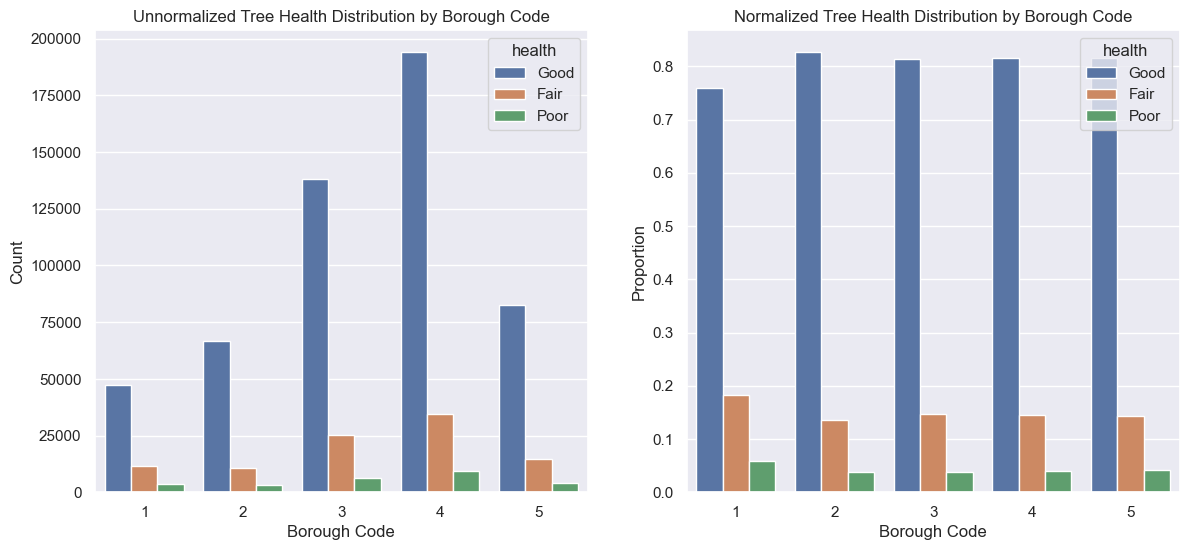

In [14]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme("notebook")

# Convert the unnormalized distribution into a DataFrame.
unnormalized_data = []
for borocode, dist in borocode_dist.items():
    for health, count in dist.items():
        unnormalized_data.append([borocode, health, count])

# Convert the normalized distribution into a DataFrame.
normalized_data = []
for borocode, dist in normalized_borocode_dist.items():
    for health, proportion in dist.items():
        normalized_data.append([borocode, health, proportion])

# Create DataFrames.
df_borocode_unnormalized = pd.DataFrame(unnormalized_data, columns=['borocode', 'health', 'count'])
df_borocode_normalized = pd.DataFrame(normalized_data, columns=['borocode', 'health', 'proportion'])

# Set up the subplots.
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot the unnormalized distribution.
sns.barplot(x='borocode', y='count', hue='health', data=df_borocode_unnormalized, ax=axes[0])
axes[0].set_title('Unnormalized Tree Health Distribution by Borough Code')
axes[0].set_xlabel('Borough Code')
axes[0].set_ylabel('Count')

# Plot the normalized distribution.
sns.barplot(x='borocode', y='proportion', hue='health', data=df_borocode_normalized, ax=axes[1])
axes[1].set_title('Normalized Tree Health Distribution by Borough Code')
axes[1].set_xlabel('Borough Code')
axes[1].set_ylabel('Proportion')

plt.show()

Normalized distribution by borough code tells us that the borough code provides little prior for deducing the tree health, because the distributions of tree health per borough code are quite similar. I am going to drop all of the location-related features, except X/Y-coordinates and longitude/latitude, because they are analyzed below.

In [15]:
# Drop location-related features.
df.drop(columns=loc_rel_features, inplace=True)

## Longitude/Latitude or X/Y?

Metadata provided along with the data hints that the longitude/latitude and X/Y-coordinate fields are duplicating each other. The figure below supports this argument by showing that there is a linear relation between X-longitude and Y-latitude, which implies that one of these measures is redundant.

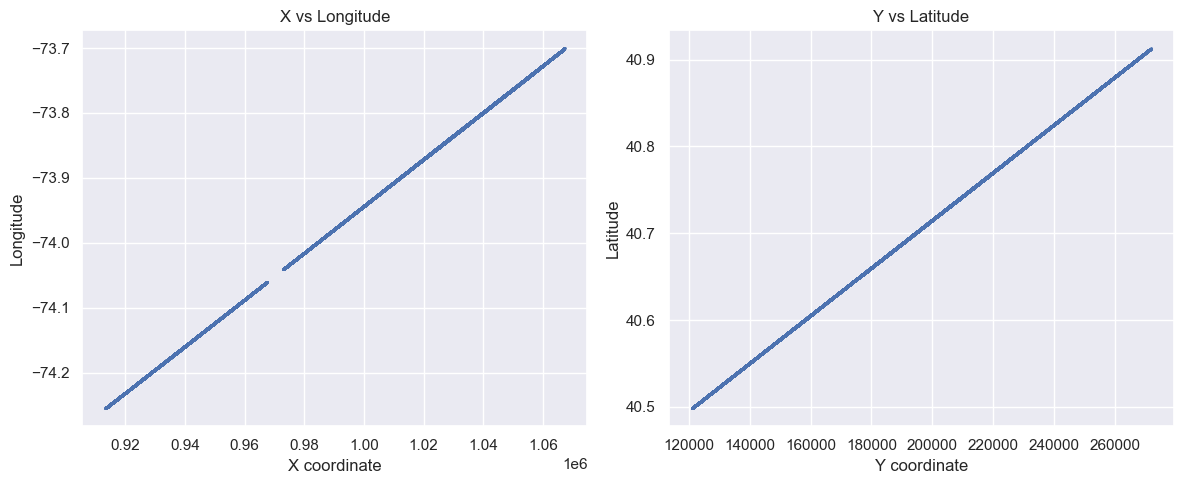

In [16]:
import seaborn as sns
from matplotlib import pyplot as plt

plt.rcParams['agg.path.chunksize'] = 1000
sns.set_theme("notebook")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.scatter(df['x_sp'].tolist(), df['longitude'], s=1)
ax1.set_xlabel("X coordinate")
ax1.set_ylabel("Longitude")
ax1.set_title("X vs Longitude")

ax2.scatter(df['y_sp'].tolist(), df['latitude'], s=1)
ax2.set_xlabel("Y coordinate")
ax2.set_ylabel("Latitude")
ax2.set_title("Y vs Latitude")

plt.tight_layout()
plt.show()


How do we know which one to drop? I decided to drop the measures which are less fine-grained. The smaller the least fraction compared to the maximum range between any 2 points belonging to the same field/column, the more fine-grained it is.

Based on the analysis below, we can conclude that the X/Y measures, despite having a (almost) 1-to-1 mapping to longitude and latitude, are more fine-grained, hence it makes sense to use them. Based on this conclusion, the X/Y coordinate columns are preserved, while longitude/latitude are dropped.

In [17]:
import numpy as np

def get_min_distance(arr):
    """
    Returns the minimum non-zero distance between any 2 values in the array.
    """
    sorted_arr = np.sort(np.array(arr))
    distances = np.diff(sorted_arr)
    nonzero_distances = distances[distances > 0]
    return np.min(nonzero_distances).item()

# Compute the minimum non-zero distance between any 2 values in the following arrays: 
# 1. X-coordinates (x_sp) 
# 2. Y-coordinates (y_sp) 
# 3. Longitude (longitude)
# 4. Latitude (latitude)
x_min_dist      = get_min_distance(df['x_sp'].tolist())         # minimum distance between any 2 x-coordinates
y_min_dist      = get_min_distance(df['y_sp'].tolist())         # minimum distance between any 2 y-coordinates
long_min_dist   = get_min_distance(df['longitude'].tolist())    # minimum distance between any 2 longitude values
lat_min_dist    = get_min_distance(df['latitude'].tolist())     # minimum distance between any 2 latitude values

x_range         = max(df['x_sp']) - min(df['x_sp'])             # x_max - x_min
y_range         = max(df['y_sp']) - min(df['y_sp'])             # y_max - y_min
long_range      = max(df['longitude']) - min(df['longitude'])   # longitude_max - longitude_min
lat_range       = max(df['latitude']) - min(df['latitude'])     # latitude_max - latitude_min

# Using the minimum distances, find which metric is more fine-grained by computing how small of a fraction of the maximum distance it covers.
x_frac          = x_min_dist / x_range                          # fraction of the minimum x distance
y_frac          = y_min_dist / y_range                          # fraction of the minimum y distance
long_frac       = long_min_dist / long_range                    # fraction of the minimum longitude distance
lat_frac        = lat_min_dist / lat_range                      # fraction of the minimum latitude distance

print(x_frac, long_frac)
print(y_frac, lat_frac)

1.949338252436119e-09 1.80350171394564e-08
1.98780406177423e-09 2.4128221410871738e-08


In [18]:
# Drop longitude and latitude because they are redundant.
df.drop(columns=['longitude', 'latitude'], inplace=True)

## X/Y vs Tree Health

Below is a plot outlining the distribution of tree health on an X-Y plane.

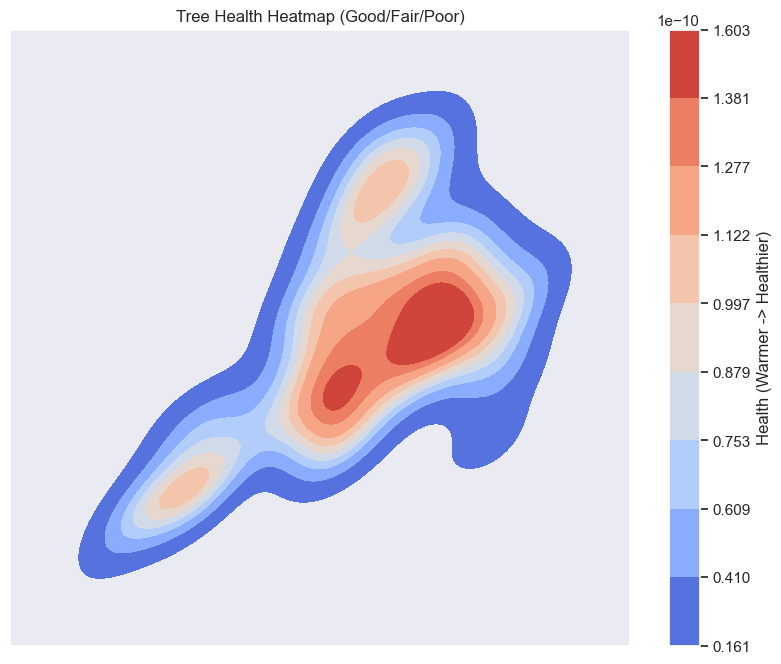

In [19]:
# Plot a sample of the dataset. Plotting all 600k points is too heavy.
df_sub = df.sample(n=1000, random_state=42)
health_map = {'Good': 1.0, 'Fair': 0.5, 'Poor': 0.0}
df_sub['health_score'] = df_sub['health'].map(health_map)

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.kdeplot(
    x=df_sub['x_sp'],
    y=df_sub['y_sp'],
    weights=df_sub['health_score'],
    fill=True,
    cmap='coolwarm'
)
mappable = ax.collections[0]
fig.colorbar(mappable, ax=ax, label='Health (Warmer -> Healthier)')

ax.set_title('Tree Health Heatmap (Good/Fair/Poor)')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticks([])
ax.set_yticks([])

plt.show()

There is clearly a distribution of the tree health depending on its location based on X/Y-coordinates. 
While location itself does not directly affect the tree health, but it indirectly does -- there might be soil health distribution which is reflected in the tree health. Therefore, we will keep these parameters in the dataset.

## Distribution of Dates

Trees have been mapped at different dates. See the distribution of the dates below.

In [20]:
# Convert 'created_at' column to datetime object.
df['created_at_datetime'] = pd.to_datetime(df['created_at'])
df[["created_at", "created_at_datetime"]]

,created_at,created_at_datetime
0,2015-08-27T00:00:00.000,2015-08-27
1,2015-09-03T00:00:00.000,2015-09-03
2,2015-09-05T00:00:00.000,2015-09-05
3,2015-09-05T00:00:00.000,2015-09-05
4,2015-08-30T00:00:00.000,2015-08-30
...,...,...
683783,2015-08-18T00:00:00.000,2015-08-18
683784,2015-08-29T00:00:00.000,2015-08-29
683785,2015-08-22T00:00:00.000,2015-08-22
683786,2015-08-29T00:00:00.000,2015-08-29


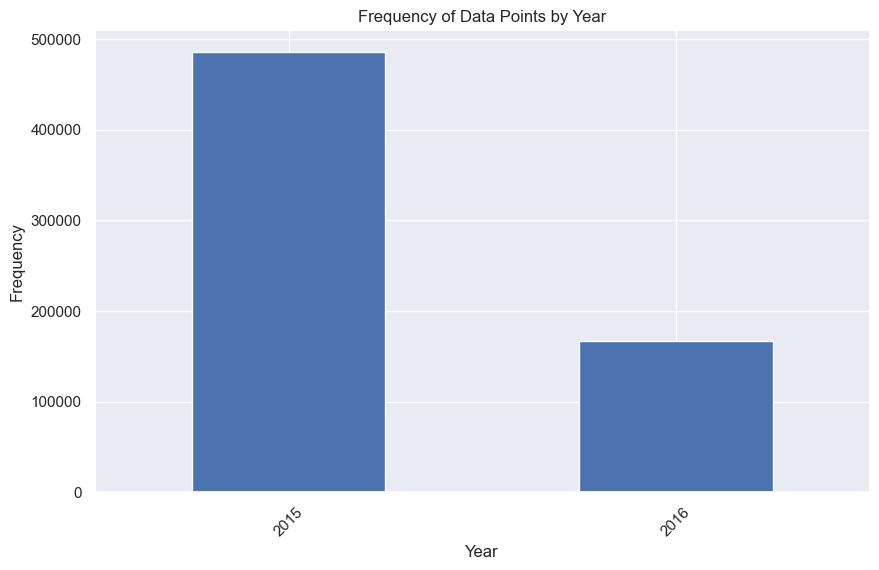

In [21]:
# Plot the number of dates groupped by years.
df['year'] = df['created_at_datetime'].dt.year
fig, ax = plt.subplots(figsize=(10, 6))
df['year'].value_counts().sort_index().plot(kind='bar')
ax.set_xlabel('Year')
ax.set_ylabel('Frequency')
ax.set_title('Frequency of Data Points by Year')
plt.xticks(rotation=45)
plt.show()

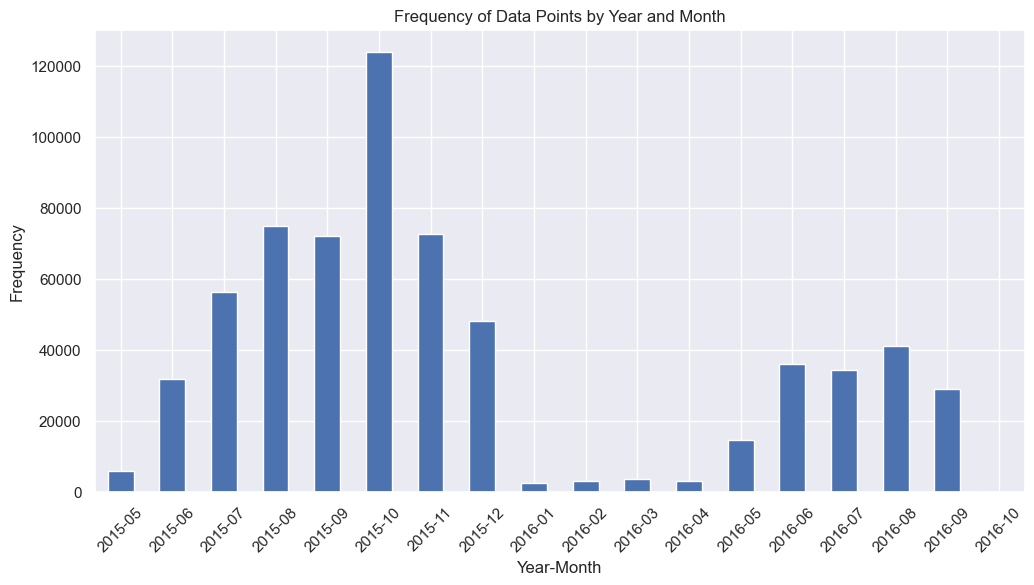

In [22]:
# Plot histogram of frequency by year and month.
df['year_month'] = df['created_at_datetime'].dt.to_period('M')
plt.figure(figsize=(12, 6))
df['year_month'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Year-Month')
plt.ylabel('Frequency')
plt.title('Frequency of Data Points by Year and Month')
plt.xticks(rotation=45)
plt.show()

All of the data has been captured pretty recently: in 2015-2016. Most of the data (about 480k records) were captured in 2015, while the remaining part (about 170k) were captured in 2016. 

Very little data was captured in the first 4 months of 2016: from January to April inclusively.

In [23]:
# Drop unnecessary columns.
df.drop(columns=["year", "year_month"], inplace=True)

The date when the record was taken should not matter for predicting the tree health. 
Moreover, during inference new data will come at **out-of-distribution** dates which could lead to problems because of overfitting to older dates. 
Additionally, according to the documentation, the `date` field represents not the date when the tree was inspected, but rather when the record was entered into the system, which introduces some uncertainty about this parameter.

The distribution above reassures that there are no major inconsistencies in the data based, hence no data needs to be removed, and we can instead simply drop the date field.

In [24]:
df.drop(columns=['created_at', 'created_at_datetime'], inplace=True)

## Does the tree species matter?

In [25]:
print(df.spc_latin.nunique())

132


The tree species should not matter for predicting a tree's health, hence discard it. Moreover, there are simply too many classes of tree species (132). This is not informative.

In [26]:
df.drop(columns=['spc_latin'], inplace=True)

## User Type

Let's check whether there is any difference between data recorded by different user types. If we see a serious difference in distributions, it's a sign that the data was not collected consistently between different user types.

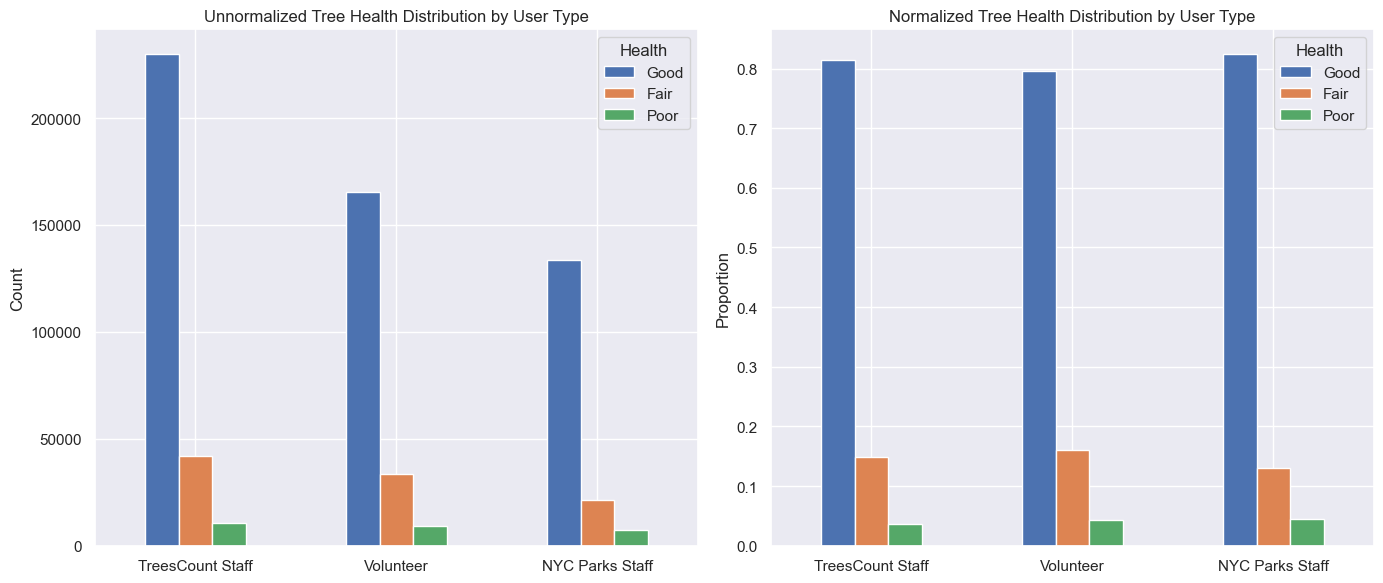

In [57]:
# Extract the user type distribution
user_type_vs_health_dist = {}
for user_type in df.user_type.unique():
    user_type_vs_health_dist[user_type] = {
        k: v for k, v in df[df.user_type == user_type].health.value_counts().items()
    }

# Convert to a DataFrame and transpose
df_plot = pd.DataFrame(user_type_vs_health_dist).T  # Rows: user types, Columns: health status

# Fill missing values (e.g. some user types may not have all health categories)
df_plot = df_plot.fillna(0)

# Normalized version (percentages)
df_norm = df_plot.div(df_plot.sum(axis=1), axis=0)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True)

# Raw counts
df_plot.plot(kind='bar', ax=axes[0])
axes[0].set_title('Unnormalized Tree Health Distribution by User Type')
axes[0].set_ylabel('Count')
axes[0].legend(title='Health')
axes[0].tick_params(axis='x', rotation=0)

# Normalized (percentages)
df_norm.plot(kind='bar', ax=axes[1])
axes[1].set_title('Normalized Tree Health Distribution by User Type')
axes[1].set_ylabel('Proportion')
axes[1].legend(title='Health')
axes[1].tick_params(axis='x', rotation=0)

# plt.xlabel('User Type')
plt.tight_layout()
plt.show()

There is little difference between the normalized distributions, suggesting that the different user types were quite consistent between each other when collecting data. While the fact who collected the data does not directly affect the tree health, it can affect the **label** assigned to the tree health. Therefore, we will keep this parameter.

## Null Values

Handle the null values.

In [26]:
df.isnull().sum()

tree_dbh           0
curb_loc           0
health             1
steward       487823
guards        572307
sidewalk           1
user_type          0
root_stone         0
root_grate         0
root_other         0
trunk_wire         0
trnk_light         0
trnk_other         0
brch_light         0
brch_shoe          0
brch_other         0
x_sp               0
y_sp               0
dtype: int64

`Steward` and `guard` fields can be filled with `None` values wherever its a `null` value.

In [27]:
df['steward'] = df['steward'].fillna('None')
df['guards'] = df['guards'].fillna('None')

Null values in other fields are so little that we can simply remove those records without in any significant way affecting the amount of data available.

In [28]:
print(len(df))
df.dropna(inplace=True)
print(len(df))

652173
652171


In [29]:
df.isnull().sum() # there should be no null values left

tree_dbh      0
curb_loc      0
health        0
steward       0
guards        0
sidewalk      0
user_type     0
root_stone    0
root_grate    0
root_other    0
trunk_wire    0
trnk_light    0
trnk_other    0
brch_light    0
brch_shoe     0
brch_other    0
x_sp          0
y_sp          0
dtype: int64

## Tree diameter vs health

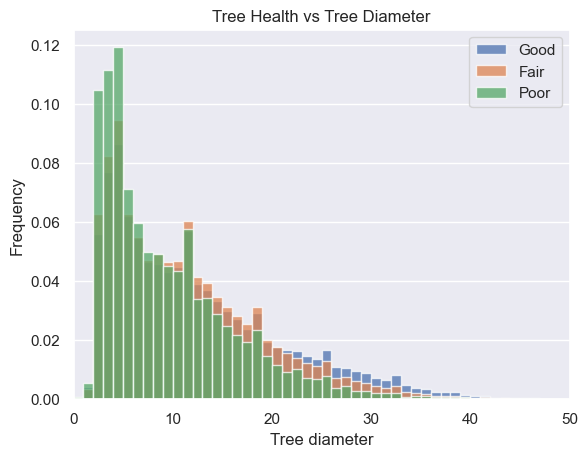

In [30]:
fig, ax = plt.subplots()

for health in ["Good", "Fair", "Poor"]:
    ax.hist(
        df[df['health'] == health]['tree_dbh'],
        # bins=200,
        bins=np.linspace(0, 50, 51),
        label=health,
        alpha=0.75,
        density=True # comment this line to see the unnormalized distribution
    )
ax.set_xlim([0, 50])
ax.set_title("Tree Health vs Tree Diameter")
ax.set_xlabel("Tree diameter")
ax.set_ylabel("Frequency")
ax.grid(axis='x')
ax.legend()

plt.show()

It looks like healthier trees have a heavier distribution tail towards larger diameters. Moreover, weaker trees are more likely to have diameters in the approximate range of [0, 8].

It sort of makes sense, because weaker trees either are too young (hence thinner) or simply don't get enough nutrition to grow wider.

## Summary of the Remaining Data

In [31]:
print(f"Data points preserved: {len(df)}")
print(f"Features preserved: {len(df.columns)}")
print(f"Number of null values: {sum(df.isnull().sum())}")
print("-" * 80)
print(f"Number of classes per categorical variable:\n{df[df.columns[df.dtypes == 'object']].nunique()}")

Data points preserved: 652171
Features preserved: 18
Number of null values: 0
--------------------------------------------------------------------------------
Number of classes per categorical variable:
curb_loc      2
health        3
steward       4
guards        4
sidewalk      2
user_type     3
root_stone    2
root_grate    2
root_other    2
trunk_wire    2
trnk_light    2
trnk_other    2
brch_light    2
brch_shoe     2
brch_other    2
dtype: int64


# Conflicting Records (IMPORTANT)

In our dataset, we have very little **local** features describing the trees, i.e. features which directly affect the tree health (e.g. the presence of problems with the root, or the absence of guards). Given that the number of records in the dataset is significantly greater than the number of local features, it can lead to a very serious problem from the ML perspective: the same **local** features might map to different labels. Consider the example below.

In [104]:
def get_one_conflicting_group(df):
    input_cols = [col for col in df.columns if col not in ['tree_dbh', 'x_sp', 'y_sp', 'user_type', 'health_Good', 'health_Fair', 'health_Poor']]
    target_cols = ['health_Good', 'health_Fair', 'health_Poor']

    # Group by input columns and check how many unique one-hot target combinations exist per group
    label_variation = df.groupby(input_cols)[target_cols].nunique()

    # Identify input combinations where any label column has more than 1 unique value
    conflicting_input_combos = label_variation[(label_variation > 1).any(axis=1)].index

    # Take the first conflicting input combination
    first_conflict = conflicting_input_combos[0]

    # Convert the MultiIndex to a dictionary
    conflict_dict = dict(zip(input_cols, first_conflict))

    # Use `.loc` with masking to select rows matching the conflict input
    mask = df[input_cols].eq(pd.Series(conflict_dict)).all(axis=1)

    conflicting_group = df[mask].copy()

    return conflicting_group


In [105]:
data = pd.get_dummies(
    df, 
    columns=['health'], 
    prefix='health',
    dtype=np.float64
)

x = get_one_conflicting_group(data)

In [106]:
x.drop(columns=['health_Poor', 'health_Good', 'health_Fair'])

,tree_dbh,curb_loc,steward,guards,sidewalk,user_type,root_stone,root_grate,root_other,trunk_wire,trnk_light,trnk_other,brch_light,brch_shoe,brch_other,x_sp,y_sp
392347,8,OffsetFromCurb,1or2,Harmful,Damage,Volunteer,No,No,No,No,No,No,No,No,No,1.000501e+06,182524.9716
392398,12,OffsetFromCurb,1or2,Harmful,Damage,Volunteer,No,No,No,No,No,No,No,No,No,1.000541e+06,182522.1291
394503,14,OffsetFromCurb,1or2,Harmful,Damage,Volunteer,No,No,No,No,No,No,No,No,No,1.000521e+06,182523.5576
401264,15,OffsetFromCurb,1or2,Harmful,Damage,Volunteer,No,No,No,No,No,No,No,No,No,1.000480e+06,182526.4001
542399,26,OffsetFromCurb,1or2,Harmful,Damage,TreesCount Staff,No,No,No,No,No,No,No,No,No,9.995225e+05,201262.4204
542969,18,OffsetFromCurb,1or2,Harmful,Damage,Volunteer,No,No,No,No,No,No,No,No,No,9.968706e+05,231094.3023
551924,17,OffsetFromCurb,1or2,Harmful,Damage,TreesCount Staff,No,No,No,No,No,No,No,No,No,9.836722e+05,205049.8911
558864,13,OffsetFromCurb,1or2,Harmful,Damage,TreesCount Staff,No,No,No,No,No,No,No,No,No,1.005551e+06,186677.6739
559052,10,OffsetFromCurb,1or2,Harmful,Damage,TreesCount Staff,No,No,No,No,No,No,No,No,No,1.005426e+06,186686.5857
559874,15,OffsetFromCurb,1or2,Harmful,Damage,TreesCount Staff,No,No,No,No,No,No,No,No,No,1.005321e+06,186694.1437


In [103]:
x[['health_Poor', 'health_Good', 'health_Fair']]

,health_Poor,health_Good,health_Fair
542399,0.0,1.0,0.0
551924,0.0,0.0,1.0
558864,0.0,0.0,1.0
559052,0.0,1.0,0.0
559874,0.0,0.0,1.0
560671,0.0,0.0,1.0
568273,0.0,0.0,1.0
568358,0.0,0.0,1.0
574249,0.0,0.0,1.0


As you can notice, for the same set of **local** variables, such as `guards`, `sidewalk`, etc, the target labels are different. This is a very serious limitation of this dataset. 

Think of it this way: for the same set of **local** variables, one tree is labeled is healthy, but another tree that's located somewhere nearby is labeled as poor. This will force the model to learn the distribution based on non-local variables (such as X/Y coordinates), leading to incredible non-linearities in the latent space of the model. In other words, it won't learn what it should learn.

The solution is to remove these conflicting records. However, it will cut a very big chunk of the data.